In [ ]:
# code in https://www.kaggle.com/code/dharun4772/adac-rag-to-do
# To extract text from PDFs
!pip install pypdf2

# To automatically detect and install GPU dependencies
!apt-get install -y pciutils
!apt-get install -y lshw

# Ollama on Kaggle hack available at: 
# https://stackoverflow.com/questions/78394289/running-ollama-on-kaggle
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) # Runs on a different thread
!ollama pull llama3 
!ollama pull mxbai-embed-large
!pip install ollama chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.9 MB/s eta 0:00:00



The following additional packages will be installed:
  libpci3 pci.ids
The following NEW packages will be installed:
  libpci3 pci.ids pciutils
0 upgraded, 3 newly installed, 0 to remove and 62 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,581 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 343 kB in 0s (1,375 kB/s)
Selecting previously unselected package pci.ids.
(Reading database ... 127400 files and directories currently installed.)
Preparing to unpack .../pci.ids_0.0~2022.01.22-1_all.deb ...
Unpacking pci.ids (0.0~2022.01.22-1) ...
Selecting previously unselected package libpci3:amd64.
Preparing to unpack

In [2]:
process = subprocess.Popen("ollama serve", shell=True) # Runs on a different thread
!ollama pull llama3 
!ollama pull mxbai-embed-large

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB                         
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB                         
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B                         
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B                         
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 
pulling manifest ⠙ pulling manifest ⠙ pulling manifest 
pulling 819c2adf5ce6... 100% ▕████████████████▏ 669 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling b837481ff855... 100% ▕████████████████▏   16 B                         
pulling 38badd946f91... 100% ▕████████████████▏  408 B                         
verifying sha256 digest 
writing manifest 
success 


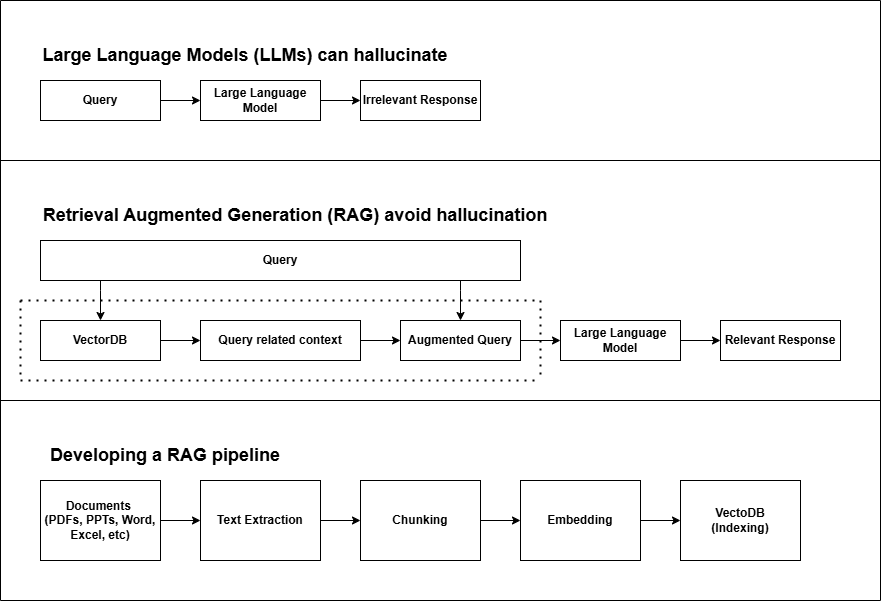

In [3]:
import chromadb
import json
import ollama

from glob import glob
from PyPDF2 import PdfReader
from tqdm import tqdm

In [4]:
query = "How do I manage my saved addresses?"

In [5]:
query_model = "llama3"

In [6]:
def get_ollama_response(question, model):

    # TO-DO
    response = ollama.chat(
        model = model,
        messages = [
            {
            'role': "user",
            'content': question
            }
        ],
        options = {
            "seed":21
        }
    )
    return response["message"]["content"]

In [7]:
response = get_ollama_response(query, query_model)
print(response)

Managing saved addresses can be convenient, but it's also important to keep them up-to-date and organized. Here are some tips on how to manage your saved addresses:

1. **Categorize and group**: Sort your saved addresses by categories like work, home, or contacts. You can also create groups based on relationships (e.g., family, friends, colleagues).
2. **Use a centralized location**: Keep all your saved addresses in one place, such as an address book app, note-taking app, or digital contact manager. This will help you keep track of updates and changes.
3. **Keep them up-to-date**: Regularly update your saved addresses to reflect any changes (e.g., new phone number, email, or address).
4. **Prioritize**: Identify the most important contacts and make sure their information is easily accessible.
5. **Consider sharing**: Share your saved addresses with trusted individuals or organizations, like family members or colleagues, for added convenience.
6. **Back up regularly**: Save a copy of yo

## Extraction 

In [8]:
def read_pdf(file_path):
    reader = PdfReader(file_path)
    content = ""
    for page in reader.pages:
        content+=page.extract_text()
    return content

In [9]:
text = read_pdf("/kaggle/input/customer-support-data/FAQs.pdf")
print(text)

Account Management (1 –15) 
1. How do I create an Amazon account?  
o Click "Sign Up" on the homepage, enter your details, verify your email, and set a 
password.  
2. How do I change my email address?  
o Go to "Account Settings" > "Login & Security" and update your email address.  
3. Can I have multiple accounts?  
o Yes, but each account must have a unique email address.  
4. How do I recover a forgotten password?  
o Click "Forgot Password?" on the login page and follow the instructions to reset it.  
5. How do I close my Amazon account?  
o Contact Customer Support and request account closure.  
6. How do I enable two -factor authentication (2FA)?  
o Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  
7. How do I check my account activity?  
o Access "Login & Security" to view login history and active sessions.  
8. What is a Prime account?  
o Prime offers benefits like faster shipping, streaming services, and exclusive deals for a 
monthly fee.  
9. Ho

## Chunking

In [10]:
def chunk_text(text, max_chars=2000, overlap=200):

    chunks = []
    start = 0
    while start<len(text):
        end = min(start+max_chars, len(text))
        chunks.append(text[start:end])
        start+=max_chars - overlap    
    return chunks

In [11]:
chunks = chunk_text(text, max_chars=2000, overlap=200)
chunks

['Account Management (1 –15) \n1. How do I create an Amazon account?  \no Click "Sign Up" on the homepage, enter your details, verify your email, and set a \npassword.  \n2. How do I change my email address?  \no Go to "Account Settings" > "Login & Security" and update your email address.  \n3. Can I have multiple accounts?  \no Yes, but each account must have a unique email address.  \n4. How do I recover a forgotten password?  \no Click "Forgot Password?" on the login page and follow the instructions to reset it.  \n5. How do I close my Amazon account?  \no Contact Customer Support and request account closure.  \n6. How do I enable two -factor authentication (2FA)?  \no Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  \n7. How do I check my account activity?  \no Access "Login & Security" to view login history and active sessions.  \n8. What is a Prime account?  \no Prime offers benefits like faster shipping, streaming services, and exclusive deals for a \n

## Embedding

In [12]:
embedding_model = "mxbai-embed-large"

In [13]:
def generate_embedding(chunk, model):

    response = ollama.embeddings(
        model = model,
        prompt = chunk,
        options = {
            "seed":21
        }
    )
    return response["embedding"]

In [14]:
chunk = chunks[0]
embedding = generate_embedding(chunk, embedding_model)
print(embedding)

[0.285856157541275, -0.011380329728126526, -0.6473504900932312, 0.33177271485328674, 0.3513453006744385, -0.12764638662338257, -0.09370623528957367, 0.24322447180747986, 1.28146493434906, 0.2230149656534195, -0.1610950231552124, 0.42476314306259155, 0.2027437686920166, -0.019028589129447937, -0.26282212138175964, 0.30328887701034546, -0.42994824051856995, -0.07729443162679672, 0.17008301615715027, -0.7647926807403564, 0.5892722606658936, -0.22975832223892212, -1.1465870141983032, 0.06253013014793396, -0.26394030451774597, 0.046510472893714905, -0.5882096290588379, 0.5145496726036072, 1.1324318647384644, 0.8030213713645935, -1.0179345607757568, 0.36098697781562805, 0.9664139151573181, -0.307639479637146, -0.4811251163482666, 0.12451502680778503, 0.5313089489936829, -0.2659699320793152, -1.3978618383407593, -0.45798906683921814, 0.3118031322956085, -0.8691719770431519, 1.1543067693710327, 0.05143062025308609, -1.143326997756958, 0.213199645280838, -0.21515107154846191, -0.218027815222740

## Indexing with VectorDB

In [15]:
client = chromadb.Client()
collection = client.create_collection(name="docs")

In [16]:
# Insert record
# TO-DO

In [17]:
# View record 
# TO-DO

In [18]:
# Delete record
# TO-DO

In [19]:
# View record 
# TO-DO

#### Combining everything

In [20]:
# Paths to PDFs
pdf_paths = glob("/kaggle/input/customer-support-data/*.pdf")
print(pdf_paths)

['/kaggle/input/customer-support-data/FAQs.pdf', '/kaggle/input/customer-support-data/how-to-guides.pdf', '/kaggle/input/customer-support-data/product-information.pdf']


In [21]:
for i, path in tqdm(enumerate(pdf_paths)):
    
    # Extraction
    text = read_pdf(path)
    
    # Chunking
    chunks = chunk_text(text, max_chars=2000, overlap=200)
    
    # Embedding
    for c, chunk in enumerate(chunks):
        embedding = generate_embedding(chunk, embedding_model)

        # Storing
        collection.add(
            ids=[f"{i}{c}"], 
            embeddings=[embedding], 
            documents=[chunk],  
        )

3it [00:01,  1.65it/s]


### Query VectorDB

In [22]:
query_embedding = generate_embedding(query, embedding_model)

k = 3 # For kNN search

# https://stackoverflow.com/questions/76482987/chroma-database-embeddings-none-when-using-get
results = collection.query(
  query_embeddings = [query_embedding],
  n_results = k
)

results

{'ids': [['00', '12', '01']],
 'embeddings': None,
 'documents': [['Account Management (1 –15) \n1. How do I create an Amazon account?  \no Click "Sign Up" on the homepage, enter your details, verify your email, and set a \npassword.  \n2. How do I change my email address?  \no Go to "Account Settings" > "Login & Security" and update your email address.  \n3. Can I have multiple accounts?  \no Yes, but each account must have a unique email address.  \n4. How do I recover a forgotten password?  \no Click "Forgot Password?" on the login page and follow the instructions to reset it.  \n5. How do I close my Amazon account?  \no Contact Customer Support and request account closure.  \n6. How do I enable two -factor authentication (2FA)?  \no Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  \n7. How do I check my account activity?  \no Access "Login & Security" to view login history and active sessions.  \n8. What is a Prime account?  \no Prime offers benefits like

### Prompt Engineering 

In [23]:
context = results["documents"][0]

augmented_query = query + "\n\nUse the following context:\n\n"
for i, c in enumerate(context, start=1):
    augmented_query += f"{i}) {c}\n"

print(augmented_query)

How do I manage my saved addresses?

Use the following context:

1) Account Management (1 –15) 
1. How do I create an Amazon account?  
o Click "Sign Up" on the homepage, enter your details, verify your email, and set a 
password.  
2. How do I change my email address?  
o Go to "Account Settings" > "Login & Security" and update your email address.  
3. Can I have multiple accounts?  
o Yes, but each account must have a unique email address.  
4. How do I recover a forgotten password?  
o Click "Forgot Password?" on the login page and follow the instructions to reset it.  
5. How do I close my Amazon account?  
o Contact Customer Support and request account closure.  
6. How do I enable two -factor authentication (2FA)?  
o Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  
7. How do I check my account activity?  
o Access "Login & Security" to view login history and active sessions.  
8. What is a Prime account?  
o Prime offers benefits like faster shipping,

In [24]:
response = get_ollama_response(augmented_query, query_model)
print(response)

According to Amazon's Account Management and Orders/Payments sections (9 and 24), you can manage your saved addresses by going to "Account Settings" > "Your Addresses". Here, you can:

* Add new addresses
* Update existing addresses
* Delete addresses that are no longer needed

This allows you to easily store multiple shipping and billing addresses for future use.
